[[ -12. -100.]
 [   1.    0.]] [[1.]
 [0.]] [[  0. 100.]] [[0.]]


C:\Users\claud\AppData\Local\Temp\ipykernel_23844\101103634.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(beta)


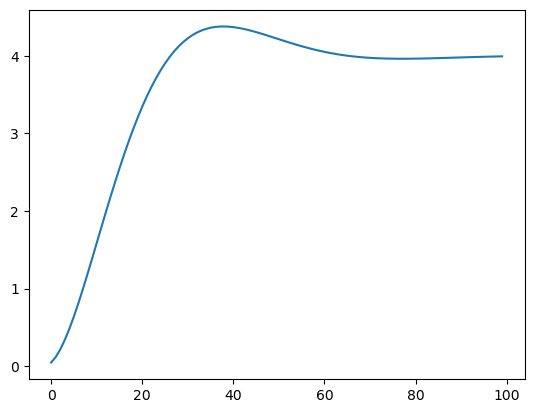

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete, tf2ss

zeta = 0.6
omega_n = 10

# Transfer function coefficients
num = [omega_n**2]
den = [1, 2*zeta*omega_n, omega_n**2]

# Convert TF → State-space
A, B, C, D = tf2ss(num, den)

Ts = 0.01  # sample time

# Now discretize the state-space system
Ad, Bd, Cd, Dd, dt = cont2discrete((A, B, C, D), Ts, method='bilinear')

print(A, B, C, D)
# Initial state
x = np.zeros((2, 1))

def pitch_update(beta_ref):
    global x

    x = Ad @ x + Bd * beta_ref

    beta = Cd @ x + Dd * beta_ref
    return float(beta)

beta_values = []
for k in range(100):
    beta = pitch_update(beta_ref=4.0)   # command pitch = 5 degrees
    beta_values.append(beta)

plt.plot(beta_values)

In [26]:
path = r'TSRxCPxPSI.csv'
df = pd.read_csv(path)
df

,TSR,-5,-4,-3,-2,-1,0,1,2,3,4,5
0,0.411942,0.0007,0.0010,0.0013,0.0015,0.0018,0.0021,0.0023,0.0026,0.0028,0.0031,0.0033
1,0.439404,0.0008,0.0011,0.0014,0.0016,0.0019,0.0022,0.0025,0.0027,0.0030,0.0033,0.0035
2,0.470790,0.0009,0.0012,0.0015,0.0018,0.0021,0.0024,0.0027,0.0030,0.0032,0.0035,0.0038
3,0.507005,0.0009,0.0013,0.0016,0.0019,0.0022,0.0026,0.0029,0.0032,0.0035,0.0038,0.0041
4,0.549255,0.0010,0.0014,0.0017,0.0021,0.0024,0.0028,0.0032,0.0035,0.0038,0.0042,0.0045
...,...,...,...,...,...,...,...,...,...,...,...,...
191,23.068729,-0.5313,-0.5180,-0.5276,-0.5396,-0.5539,-0.5790,-0.6162,-0.6788,-0.8500,-1.1788,-1.7242
192,24.167240,-0.6381,-0.6257,-0.6392,-0.6585,-0.6841,-0.7269,-0.7918,-0.8824,-1.0819,-1.4697,-2.1104
193,26.364261,-0.8841,-0.8743,-0.8973,-0.9319,-0.9832,-1.0642,-1.1895,-1.3443,-1.6264,-2.1537,-3.0514
194,28.561283,-1.1772,-1.1713,-1.2051,-1.2564,-1.3369,-1.4665,-1.6582,-1.9132,-2.2992,-3.0409,-4.1698


In [27]:
path = r'TSRxCPxPSI.csv'
df = pd.read_csv(path)
angles = np.arange(-5,6,1)
TSR = df.iloc[:,0]

def Cp_calc(LAMBDA=0, PHI=0):
    path = r'TSRxCPxPSI.csv'
    df = pd.read_csv(path)
    angles = np.arange(-5,6,1)
    TSR = df.iloc[:,0]
    diff1 = np.abs(TSR - LAMBDA)
    diff2 = np.abs(angles - PHI)
    id1 = np.argmin(diff1)
    id2 = np.argmin(diff2)+1

    return df.iloc[id1,id2]

Cp_calc(LAMBDA=7.6, PHI=1)

0.4796

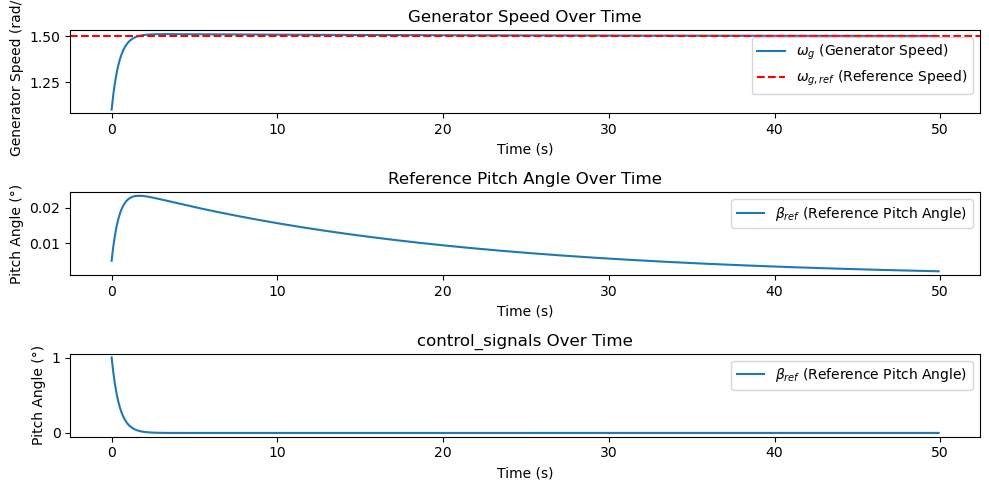

In [28]:
import numpy as np
import matplotlib.pyplot as plt

class SpeedController:
    def __init__(self, Kp, Ki, omega_ref, omega_nom):
        self.Kp = Kp    # Proportional gain
        self.Ki = Ki    # Integral gain
        self.omega_ref = omega_ref  # Desired reference speed (constant or dynamic)
        self.omega_nom = omega_nom  # Nominal generator speed
        self.error_integral = 0     # Integral of error
        self.previous_error = 0     # Previous error (for integral calculation)
        self.beta_ref = 0           # Initial reference pitch angle
    
    def compute_control(self, omega_g, dt):
        # Compute the error between reference and actual generator speed
        error = self.omega_ref - omega_g
        
        # Proportional term
        P_term = self.Kp * error
        
        # Integral term (accumulated error over time)
        self.error_integral += error * dt
        I_term = self.Ki * self.error_integral
        
        # Total control signal (output of the PI controller)
        control_signal = P_term + I_term
        
        # Update previous error for the next iteration
        self.previous_error = error
        
        # Update the reference pitch angle (using the PI feedback)
        self.beta_ref += self.Kp * error + (self.Ki * dt - self.Kp) * self.previous_error
        
        return self.beta_ref, control_signal


# Simulation parameters
Kp = 2.0   # Proportional gain
Ki = 0.1   # Integral gain
omega_ref = 1.5  # Reference generator speed (in rad/s)
omega_nom = 1.0  # Nominal generator speed (in rad/s)
T = 50  # Total simulation time (seconds)
dt = 0.1  # Time step (seconds)

# Initialize the Speed Controller
speed_controller = SpeedController(Kp, Ki, omega_ref, omega_nom)

# Initial generator speed (omega_g)
omega_g = 1.0  # Starting at the nominal speed

# Arrays to store simulation data
time_steps = np.arange(0, T, dt)
omega_g_values = []  # List to store omega_g over time
beta_ref_values = []  # List to store beta_ref (reference pitch angle) over time
control_signals = []  # List to store control signal over time

# Run the simulation
for t in time_steps:
    beta_ref, control_signal = speed_controller.compute_control(omega_g, dt)
    
    # Simulate generator speed response (just an example update rule for demo)
    omega_g = omega_g + control_signal * dt  # Update omega_g based on control signal
    
    # Store values for plotting
    omega_g_values.append(omega_g)
    beta_ref_values.append(beta_ref)
    control_signals.append(control_signal)

# Plot results
plt.figure(figsize=(10, 5))

# Plot generator speed over time
plt.subplot(3, 1, 1)
plt.plot(time_steps, omega_g_values, label=r'$\omega_g$ (Generator Speed)')
plt.axhline(omega_ref, color='r', linestyle='--', label=r'$\omega_{g,ref}$ (Reference Speed)')
plt.title("Generator Speed Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Generator Speed (rad/s)")
plt.legend()

# Plot reference pitch angle over time
plt.subplot(3, 1, 2)
plt.plot(time_steps, beta_ref_values, label=r'$\beta_{ref}$ (Reference Pitch Angle)')
plt.title("Reference Pitch Angle Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Pitch Angle (°)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time_steps, control_signals, label=r'$\beta_{ref}$ (Reference Pitch Angle)')
plt.title("control_signals Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Pitch Angle (°)")
plt.legend()

plt.tight_layout()
plt.show()


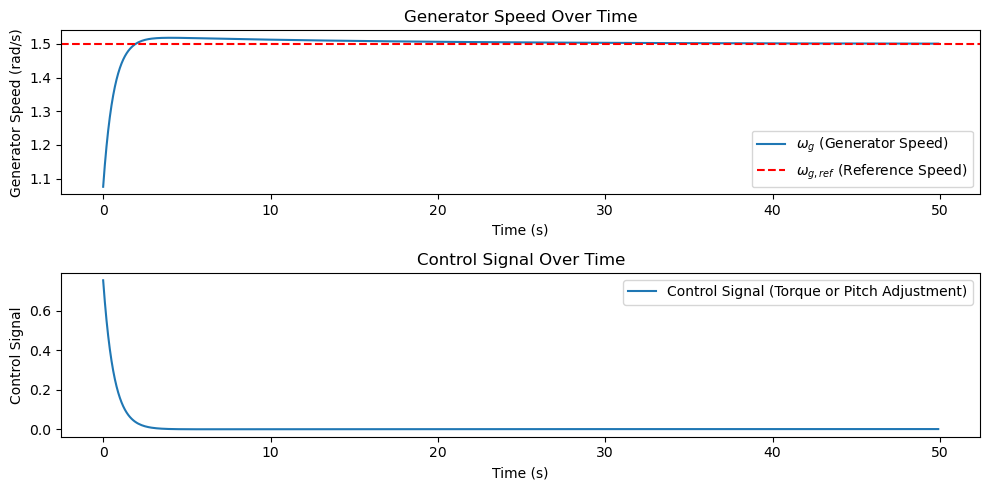

In [29]:
import numpy as np
import matplotlib.pyplot as plt

class SpeedController:
    def __init__(self, Kp, Ki, omega_ref):
        self.Kp = Kp
        self.Ki = Ki
        self.omega_ref = omega_ref
        self.error_integral = 0
        self.previous_error = 0
    
    def compute_control(self, omega_g, dt):
        error = self.omega_ref - omega_g
        P_term = self.Kp * error
        self.error_integral += error * dt
        I_term = self.Ki * self.error_integral
        control_signal = P_term + I_term
        self.previous_error = error
        return control_signal


# Simulation setup
omega_ref = 1.5  # Reference generator speed (rad/s)
omega_g = 1.0    # Initial generator speed (rad/s)
Kp = 1.5         # Initial proportional gain
Ki = 0.1         # Initial integral gain
T = 50           # Total simulation time (seconds)
dt = 0.1         # Time step (seconds)

# Create speed controller
controller = SpeedController(Kp, Ki, omega_ref)

# Arrays to store results
omega_g_values = []
control_signals = []

# Run the simulation
for t in np.arange(0, T, dt):
    control_signal = controller.compute_control(omega_g, dt)
    omega_g += control_signal * dt  # Simulate the generator speed update
    
    # Store values for plotting
    omega_g_values.append(omega_g)
    control_signals.append(control_signal)

# Plot results
plt.figure(figsize=(10, 5))

# Plot generator speed over time
plt.subplot(2, 1, 1)
plt.plot(np.arange(0, T, dt), omega_g_values, label=r'$\omega_g$ (Generator Speed)')
plt.axhline(omega_ref, color='r', linestyle='--', label=r'$\omega_{g,ref}$ (Reference Speed)')
plt.title("Generator Speed Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Generator Speed (rad/s)")
plt.legend()

# Plot control signal over time
plt.subplot(2, 1, 2)
plt.plot(np.arange(0, T, dt), control_signals, label="Control Signal (Torque or Pitch Adjustment)")
plt.title("Control Signal Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Control Signal")
plt.legend()

plt.tight_layout()
plt.show()


In [72]:
import scipy.io
mat_file_path = 'Cq.mat'

# Load the .mat file
mat_data = scipy.io.loadmat(mat_file_path)
#print(mat_data)
Cq = mat_data['Cq'].T
tsr = np.array([1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13])
Cq =np.vstack([tsr,Cq]).T
df = pd.DataFrame(Cq)
df.columns = np.array(['TSR',-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95])
df.to_csv('Cq.csv',index=False)


In [87]:
import plotly.graph_objects as go
path = r'Cq.csv'
df = pd.read_csv(path)
X = df.iloc[:, 0].values
Y = np.arange(len(df.columns)-1)
X, Y = np.meshgrid(X, Y)

Z = np.array(df.iloc[:, 1:]).T

# Create the plot
fig = go.Figure(data=[go.Surface(z=Z, x=Y, y=X, colorscale='magma')])

# Customize layout
fig.update_layout(
    scene = {
        'xaxis_title': 'Pitch angle',
        'yaxis_title': 'TSR',
        'zaxis_title': 'Z Axis',
        #'zaxis': dict(range=[-2.01, 0.5])
    },
    coloraxis_colorbar=dict(
        title="Color Scale"
    ),
)

# Show the plot
fig.show()

In [88]:
df.max()

TSR      13.0000
-2        0.0639
-1.5      0.0639
-1        0.0648
-0.75     0.0648
-0.5      0.0648
-0.25     0.0648
0         0.0648
0.25      0.0639
0.5       0.0639
0.75      0.0639
1         0.0630
1.5       0.0630
2         0.0621
3         0.0612
5         0.0567
10        0.0468
15        0.0387
20        0.0333
25        0.0297
30        0.0279
35        0.0252
40        0.0252
45        0.0225
50        0.0171
55        0.0072
60       -0.0036
65       -0.0126
70       -0.0180
75       -0.0198
80       -0.0225
85       -0.0252
90       -0.0279
95       -0.0306
dtype: float64